# Time series forecasting
Comparison of the tutorials is at the end.

## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['axes.grid'] = False

## The dataset
This dataset contains 21 different features. These were collected every day, beginning in 2nd of JAN,2021.

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [ ]:
df = pd.read_csv('/content/csv_nfl_data.csv')
date_time = pd.to_datetime(df.pop('Date(IST)'), format='%d-%m-%Y')

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,nfl_data,NFO,NFH,NFL,NFC,FIIB,FIIS,FIIN,DIIB,DIIS,DIIN,August,December,CAD,DAD,DOD,NDAD,Currey,Flow,Shine,Vega
0,1,12115.67324,12177.11996,12151.57155,12216.27237,2670.78,1982.02,688.76,3490.16,3426.21,63.95,1356.0,482.0,-0.01,0.397,-0.98,0.72,-0.0520,0.0399,-0.10,-1.309999
1,2,12195.40645,12275.48738,12173.35595,12251.19693,4514.35,3251.30,1263.05,2750.87,3780.07,-1029.20,879.0,973.0,-0.23,-0.510,-1.33,0.46,0.4430,0.5648,0.08,1.550000
2,3,12272.92902,12299.12704,12181.88753,12228.90326,3732.00,3835.84,-103.84,3778.78,3802.48,-23.70,360.0,1502.0,-0.17,0.015,-0.21,-0.07,0.0877,-0.0690,-0.18,-0.170000
3,4,12237.30935,12242.22714,12030.37114,12051.96001,3911.17,4593.40,-682.23,4205.16,3893.97,311.19,1248.0,578.0,-0.21,-0.050,-0.02,-1.79,-0.0437,-0.0208,0.08,-0.060000
4,5,12149.13785,12192.47472,11985.55562,12017.34354,4109.04,4624.89,-515.85,5162.02,4413.62,748.40,725.0,1109.0,0.56,0.305,0.54,-0.59,-0.2980,-0.6992,-0.65,-0.340000


Here is the evolution of a few features over time. 

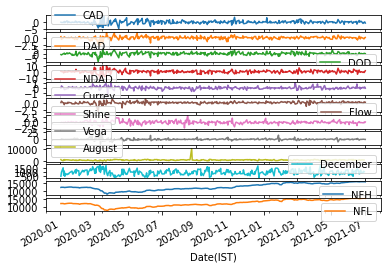

In [ ]:
plot_cols = ['CAD','DAD','DOD','NDAD','Currey','Flow','Shine','Vega','August','December','NFH','NFL']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

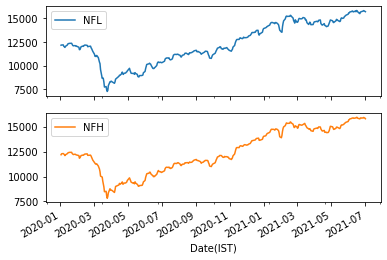

In [ ]:
plot_cols = ['NFL', 'NFH']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nfl_data,358.0,179.500000,103.489935,1.000000,90.250000,179.500000,268.750000,358.000000
NFO,358.0,12408.529835,2159.091962,7471.891708,11004.852872,12099.992490,14564.082627,15904.676770
NFH,358.0,12487.767232,2137.764769,7819.610704,11097.844655,12123.686410,14712.369227,15921.677430
NFL,358.0,12296.567036,2170.549601,7264.768634,10907.480263,12000.471730,14448.874832,15814.822030
NFC,358.0,12395.303761,2157.056045,7512.951040,11010.538050,12060.268685,14575.894975,15895.376150
FIIB,357.0,7666.212493,5414.545687,2489.450000,5184.050000,6519.910000,8493.910000,74741.850000
FIIS,357.0,7402.904678,4856.679804,1982.020000,5147.510000,6345.320000,8099.470000,67028.870000
FIIN,357.0,263.307731,2767.808949,-8295.170000,-1014.270000,125.150000,1170.890000,28739.170000
DIIB,357.0,4715.688011,1552.928036,1960.270000,3694.530000,4352.950000,5303.160000,13264.470000
DIIS,357.0,4785.561345,1283.960670,2062.950000,3912.170000,4597.660000,5575.500000,9844.670000


### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

Here, August's max value is clealry an outlier and needs to be replaced by the column mean.

In [ ]:
wv = df['August']
bad_wv = wv == 10680.000000
wv[bad_wv] = 979.067

# The above inplace edits are reflected in the DataFrame
df['August'].max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1631.0

# We drop nfl_data as it has no real use 

In [ ]:
df = df.drop("nfl_data",axis=1)
len(df)

358

# Here we fill all the missing values with the column means

In [ ]:
df.fillna(df.mean(), inplace=True)

## Time
We dont have a time column, hence we shall progress in days instead of hours from this point on.

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

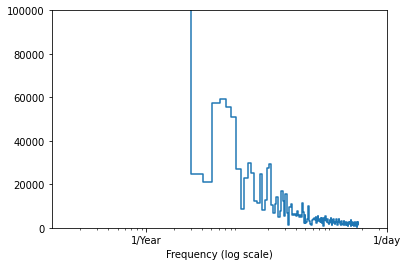

In [ ]:
fft = tf.signal.rfft(df['NFL'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['NFL'])
days_per_year = 1*365.2524
years_per_dataset = n_samples_h/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

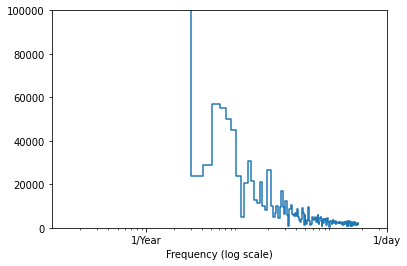

In [ ]:
fft = tf.signal.rfft(df['NFH'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['NFH'])
days_per_year = 1*365.2524
years_per_dataset = n_samples_h/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
n

358

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

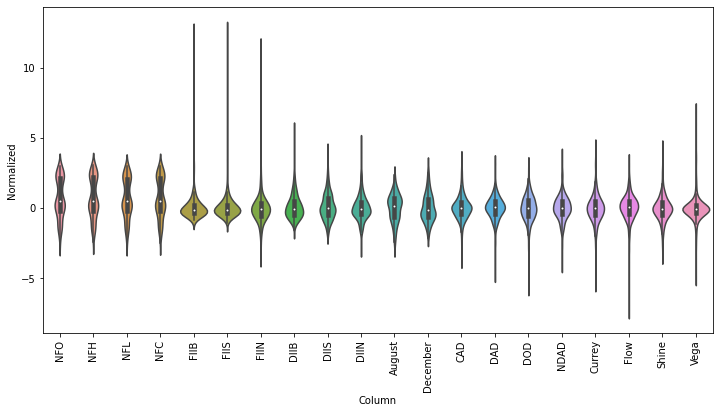

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing






### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['NFL'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['NFL']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['NFH'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['NFH']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 20)
Inputs shape: (3, 6, 20)
labels shape: (3, 1, 1)


### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

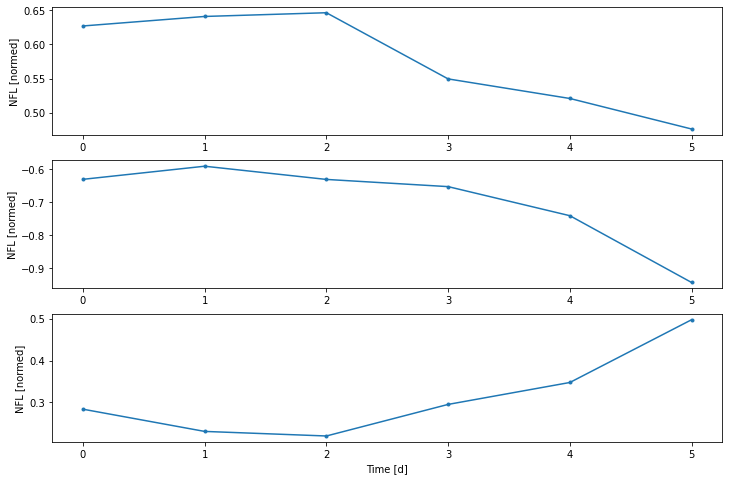

In [ ]:
w2.plot(plot_col='NFL')

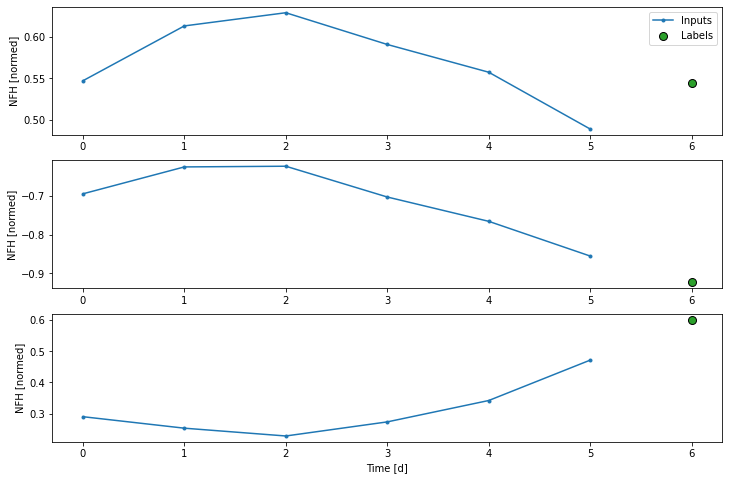

In [ ]:
w2.plot(plot_col='NFH')

### 4. Create `tf.data.Dataset`s

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 20), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 20)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1D) in the future based only on the current conditions.

So start by building models to predict the `NFL` value 1h into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

## I used two separate windows for NFL and NFH to make things easier.

In [ ]:
single_step_window1 = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['NFL'])
single_step_window1

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['NFL']

In [ ]:
single_step_window2 = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['NFH'])
single_step_window2

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['NFH']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 20)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
for example_inputs, example_labels in single_step_window2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 20)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices['NFL'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline1'] = baseline.evaluate(single_step_window1.val)
performance['Baseline1'] = baseline.evaluate(single_step_window1.test, verbose=0)

3/3 [==============================] - 0s 4ms/step - loss: 0.0116 - mean_absolute_error: 0.0846


In [ ]:
baseline2 = Baseline(label_index=column_indices['NFH'])

baseline2.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline1'] = baseline2.evaluate(single_step_window2.val)
performance['Baseline1'] = baseline2.evaluate(single_step_window2.test, verbose=0)

3/3 [==============================] - 0s 7ms/step - loss: 0.0082 - mean_absolute_error: 0.0731


In [ ]:
wide_window1 = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['NFL'])

wide_window1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['NFL']

In [ ]:
wide_window2 = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['NFH'])

wide_window2


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['NFH']

In [ ]:
print('Input shape:', wide_window1.example[0].shape)
print('Output shape:', baseline(wide_window1.example[0]).shape)

Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


In [ ]:
print('Input shape:', wide_window2.example[0].shape)
print('Output shape:', baseline(wide_window2.example[0]).shape)

Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

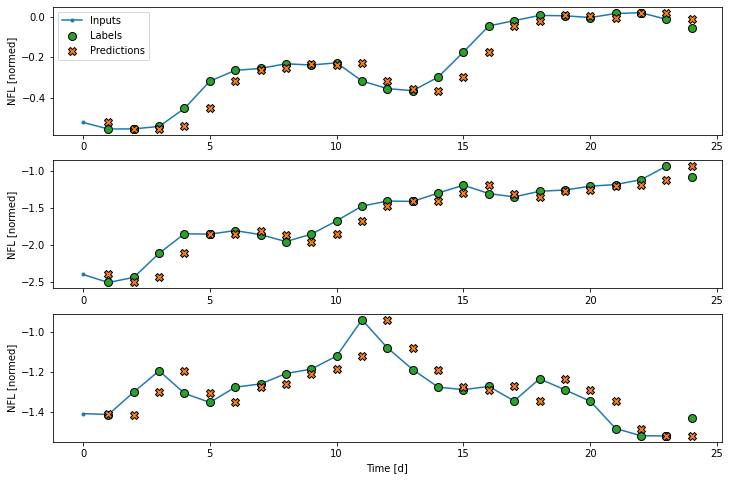

In [ ]:
wide_window1.plot(baseline,'NFL')

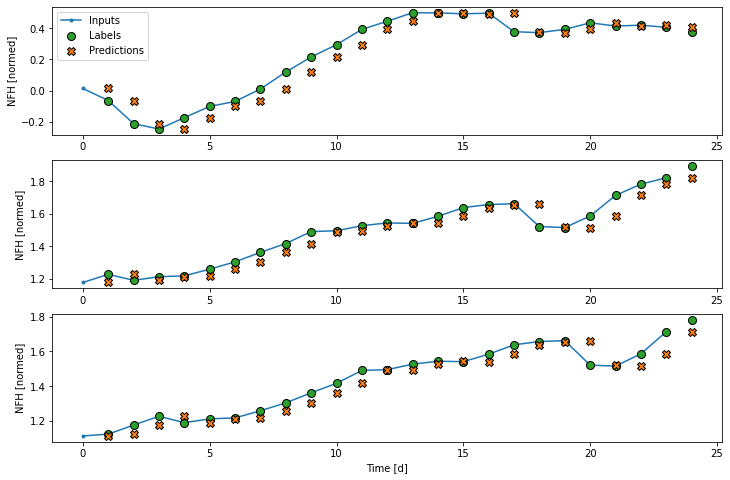

In [ ]:
wide_window2.plot(baseline2,'NFH')

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window1.example[0].shape)
print('Output shape:', linear(single_step_window1.example[0]).shape)

Input shape: (32, 1, 20)
Output shape: (32, 1, 1)


In [ ]:
print('Input shape:', single_step_window2.example[0].shape)
print('Output shape:', linear(single_step_window2.example[0]).shape)

Input shape: (32, 1, 20)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [ ]:
history1 = compile_and_fit(linear, single_step_window1)

val_performance['Linear1'] = linear.evaluate(single_step_window1.val)
performance['Linear1'] = linear.evaluate(single_step_window1.test, verbose=0)

Epoch 1/20
8/8 [==============================] - 1s 58ms/step - loss: 2.2210 - mean_absolute_error: 1.1187 - val_loss: 5.6730 - val_mean_absolute_error: 2.1367
Epoch 2/20
8/8 [==============================] - 0s 11ms/step - loss: 2.0642 - mean_absolute_error: 1.0789 - val_loss: 5.3564 - val_mean_absolute_error: 2.0734
Epoch 3/20
8/8 [==============================] - 0s 10ms/step - loss: 1.9322 - mean_absolute_error: 1.0414 - val_loss: 5.0361 - val_mean_absolute_error: 2.0072
Epoch 4/20
8/8 [==============================] - 0s 10ms/step - loss: 1.7950 - mean_absolute_error: 1.0024 - val_loss: 4.7333 - val_mean_absolute_error: 1.9425
Epoch 5/20
8/8 [==============================] - 0s 10ms/step - loss: 1.6727 - mean_absolute_error: 0.9669 - val_loss: 4.4396 - val_mean_absolute_error: 1.8767
Epoch 6/20
8/8 [==============================] - 0s 12ms/step - loss: 1.5619 - mean_absolute_error: 0.9311 - val_loss: 4.1603 - val_mean_absolute_error: 1.8126
Epoch 7/20
8/8 [==================

In [ ]:
history2 = compile_and_fit(linear, single_step_window1)

val_performance['Linear2'] = linear.evaluate(single_step_window2.val)
performance['Linear2'] = linear.evaluate(single_step_window2.test, verbose=0)

Epoch 1/20
8/8 [==============================] - 0s 22ms/step - loss: 0.5512 - mean_absolute_error: 0.5355 - val_loss: 1.5435 - val_mean_absolute_error: 1.0084
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 0.5044 - mean_absolute_error: 0.5091 - val_loss: 1.3927 - val_mean_absolute_error: 0.9410
Epoch 3/20
8/8 [==============================] - 0s 11ms/step - loss: 0.4607 - mean_absolute_error: 0.4825 - val_loss: 1.2593 - val_mean_absolute_error: 0.8784
Epoch 4/20
8/8 [==============================] - 0s 11ms/step - loss: 0.4227 - mean_absolute_error: 0.4581 - val_loss: 1.1467 - val_mean_absolute_error: 0.8239
Epoch 5/20
8/8 [==============================] - 0s 9ms/step - loss: 0.3901 - mean_absolute_error: 0.4377 - val_loss: 1.0504 - val_mean_absolute_error: 0.7755
Epoch 6/20
8/8 [==============================] - 0s 10ms/step - loss: 0.3652 - mean_absolute_error: 0.4193 - val_loss: 0.9605 - val_mean_absolute_error: 0.7279
Epoch 7/20
8/8 [===================

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window1.example[0].shape)
print('Output shape:', baseline(wide_window1.example[0]).shape)

Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


In [ ]:
print('Input shape:', wide_window2.example[0].shape)
print('Output shape:', baseline(wide_window2.example[0]).shape)

Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

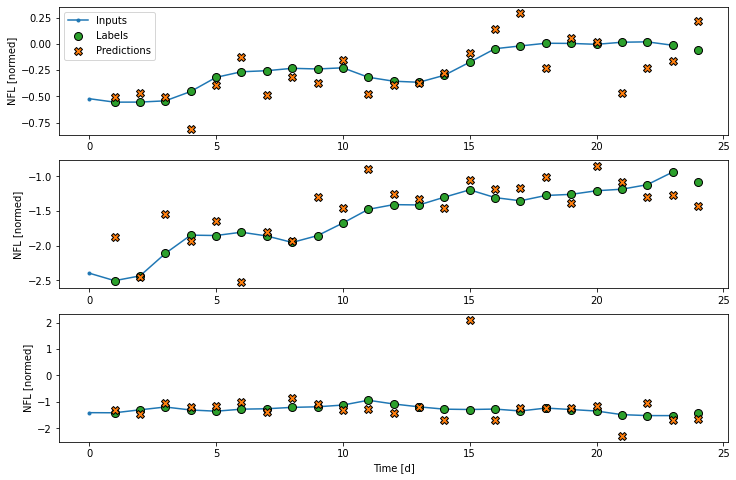

In [ ]:
wide_window1.plot(linear,'NFL')

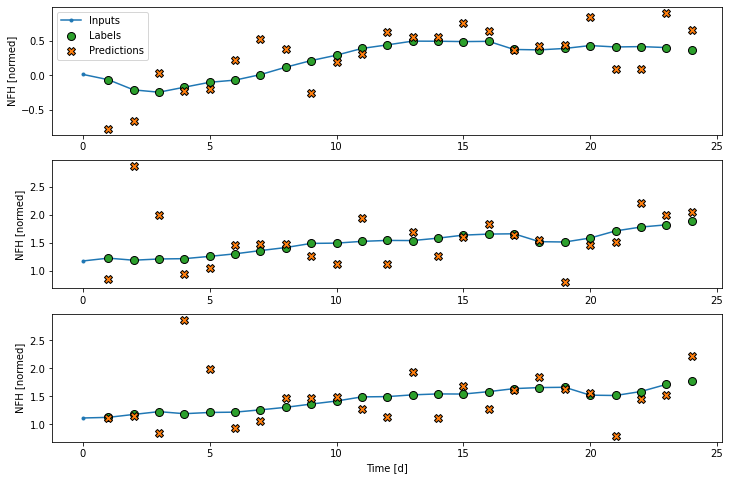

In [ ]:
wide_window2.plot(linear,'NFH')

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

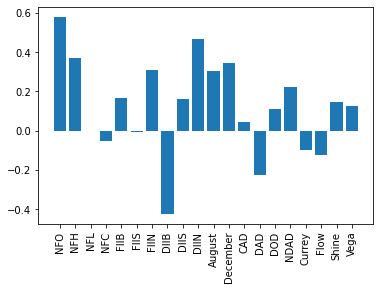

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window1)

val_performance['Dense1'] = dense.evaluate(single_step_window1.val)
performance['Dense1'] = dense.evaluate(single_step_window1.test, verbose=0)

Epoch 1/20
8/8 [==============================] - 1s 27ms/step - loss: 0.6617 - mean_absolute_error: 0.6141 - val_loss: 1.8872 - val_mean_absolute_error: 1.3402
Epoch 2/20
8/8 [==============================] - 0s 11ms/step - loss: 0.2615 - mean_absolute_error: 0.3775 - val_loss: 0.6532 - val_mean_absolute_error: 0.7159
Epoch 3/20
8/8 [==============================] - 0s 11ms/step - loss: 0.1307 - mean_absolute_error: 0.2787 - val_loss: 0.2844 - val_mean_absolute_error: 0.4243
Epoch 4/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0938 - mean_absolute_error: 0.2350 - val_loss: 0.1663 - val_mean_absolute_error: 0.3205
Epoch 5/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0557 - mean_absolute_error: 0.1837 - val_loss: 0.1274 - val_mean_absolute_error: 0.2898
Epoch 6/20
8/8 [==============================] - 0s 13ms/step - loss: 0.0356 - mean_absolute_error: 0.1482 - val_loss: 0.1104 - val_mean_absolute_error: 0.2748
Epoch 7/20
8/8 [==================

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window2)

val_performance['Dense2'] = dense.evaluate(single_step_window2.val)
performance['Dense2'] = dense.evaluate(single_step_window2.test, verbose=0)

Epoch 1/20
8/8 [==============================] - 1s 53ms/step - loss: 0.7305 - mean_absolute_error: 0.6537 - val_loss: 2.5177 - val_mean_absolute_error: 1.5584
Epoch 2/20
8/8 [==============================] - 0s 22ms/step - loss: 0.2550 - mean_absolute_error: 0.3752 - val_loss: 0.8002 - val_mean_absolute_error: 0.8247
Epoch 3/20
8/8 [==============================] - 0s 50ms/step - loss: 0.1222 - mean_absolute_error: 0.2616 - val_loss: 0.2201 - val_mean_absolute_error: 0.3716
Epoch 4/20
8/8 [==============================] - 0s 22ms/step - loss: 0.0727 - mean_absolute_error: 0.2149 - val_loss: 0.1744 - val_mean_absolute_error: 0.3398
Epoch 5/20
8/8 [==============================] - 0s 23ms/step - loss: 0.0398 - mean_absolute_error: 0.1554 - val_loss: 0.1813 - val_mean_absolute_error: 0.3573
Epoch 6/20
8/8 [==============================] - 0s 25ms/step - loss: 0.0298 - mean_absolute_error: 0.1324 - val_loss: 0.1682 - val_mean_absolute_error: 0.3495
Epoch 7/20
8/8 [==================

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [ ]:
CONV_WIDTH = 24
conv_window1 = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['NFL'])
conv_window2 = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['NFH'])

conv_window1


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['NFL']

Text(0.5, 1.0, 'Given 3d as input, predict 24d into the future.')

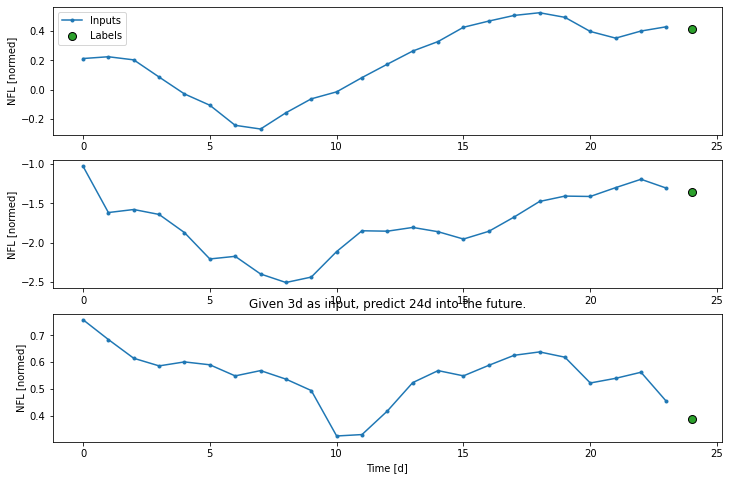

In [ ]:
conv_window1.plot(plot_col='NFL')
plt.title("Given 3d as input, predict 24d into the future.")

Text(0.5, 1.0, 'Given 3d as input, predict 24d into the future.')

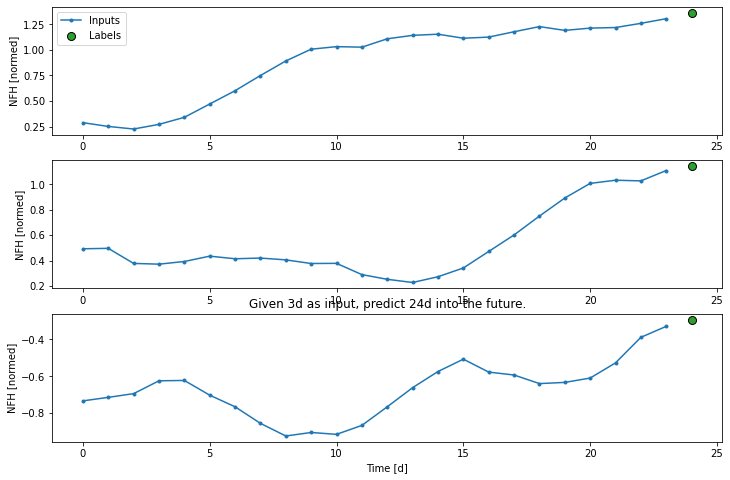

In [ ]:
conv_window2.plot(plot_col='NFH')
plt.title("Given 3d as input, predict 24d into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window1.example[0].shape)
print('Output shape:', multi_step_dense(conv_window1.example[0]).shape)
print('Input shape:', conv_window2.example[0].shape)
print('Output shape:', multi_step_dense(conv_window2.example[0]).shape)

Input shape: (32, 24, 20)
Output shape: (32, 1, 1)
Input shape: (32, 24, 20)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window1)

IPython.display.clear_output()
val_performance['Multi step dense1'] = multi_step_dense.evaluate(conv_window1.val)
performance['Multi step dense1'] = multi_step_dense.evaluate(conv_window1.test, verbose=0)

2/2 [==============================] - 0s 5ms/step - loss: 0.2511 - mean_absolute_error: 0.4170


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window2)

IPython.display.clear_output()
val_performance['Multi step dense2'] = multi_step_dense.evaluate(conv_window2.val)
performance['Multi step dense2'] = multi_step_dense.evaluate(conv_window2.test, verbose=0)

2/2 [==============================] - 0s 6ms/step - loss: 0.2322 - mean_absolute_error: 0.4003


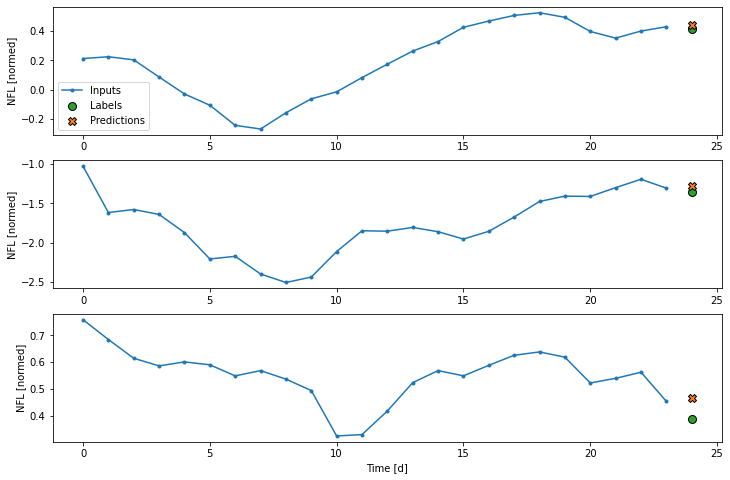

In [ ]:
conv_window1.plot(multi_step_dense,plot_col='NFL')

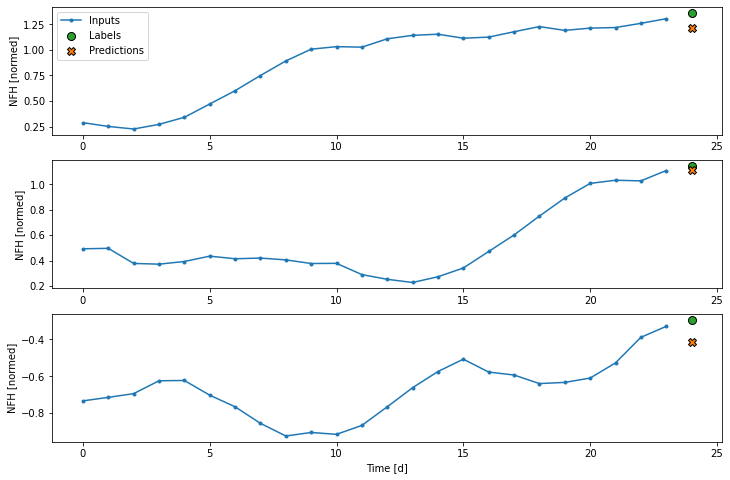

In [ ]:
conv_window2.plot(multi_step_dense,plot_col='NFH')

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [ ]:
print('Input shape:', wide_window1.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window1.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 20)
Output shape: (32, 1, 1)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [ ]:
print("Conv model on `conv_window for NFL`")
print('Input shape:', conv_window1.example[0].shape)
print('Output shape:', conv_model(conv_window1.example[0]).shape)
print("Conv model on `conv_window for NFH`")
print('Input shape:', conv_window2.example[0].shape)
print('Output shape:', conv_model(conv_window2.example[0]).shape)

Conv model on `conv_window for NFL`
Input shape: (32, 24, 20)
Output shape: (32, 1, 1)
Conv model on `conv_window for NFH`
Input shape: (32, 24, 20)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window1)

IPython.display.clear_output()
val_performance['Conv1'] = conv_model.evaluate(conv_window1.val)
performance['Conv1'] = conv_model.evaluate(conv_window1.test, verbose=0)

2/2 [==============================] - 0s 7ms/step - loss: 0.1593 - mean_absolute_error: 0.3059


In [ ]:
history = compile_and_fit(conv_model, conv_window2)

IPython.display.clear_output()
val_performance['Conv2'] = conv_model.evaluate(conv_window2.val)
performance['Conv2'] = conv_model.evaluate(conv_window2.test, verbose=0)

2/2 [==============================] - 0s 8ms/step - loss: 0.1995 - mean_absolute_error: 0.3675


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window1.example[0].shape)
print('Labels shape:', wide_window1.example[1].shape)
print('Output shape:', conv_model(wide_window1.example[0]).shape)

Wide window
Input shape: (32, 24, 20)
Labels shape: (32, 24, 1)
Output shape: (32, 1, 1)


In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window1 = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['NFL'])
wide_conv_window2 = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['NFH'])

wide_conv_window1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['NFL']

In [ ]:
print("Wide conv window for NFL")
print('Input shape:', wide_conv_window1.example[0].shape)
print('Labels shape:', wide_conv_window1.example[1].shape)
print('Output shape:', conv_model(wide_conv_window1.example[0]).shape)
print("Wide conv window for NFH")
print('Input shape:', wide_conv_window2.example[0].shape)
print('Labels shape:', wide_conv_window2.example[1].shape)
print('Output shape:', conv_model(wide_conv_window2.example[0]).shape)

Wide conv window for NFL
Input shape: (32, 47, 20)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)
Wide conv window for NFH
Input shape: (32, 47, 20)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


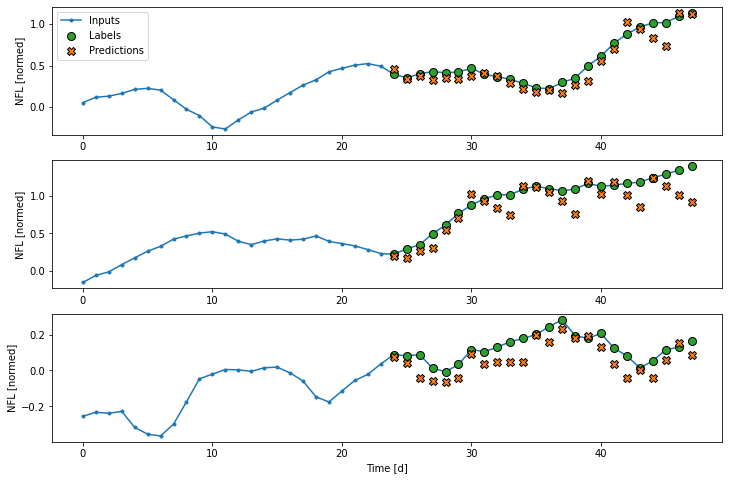

In [ ]:
wide_conv_window1.plot(conv_model,plot_col='NFL')

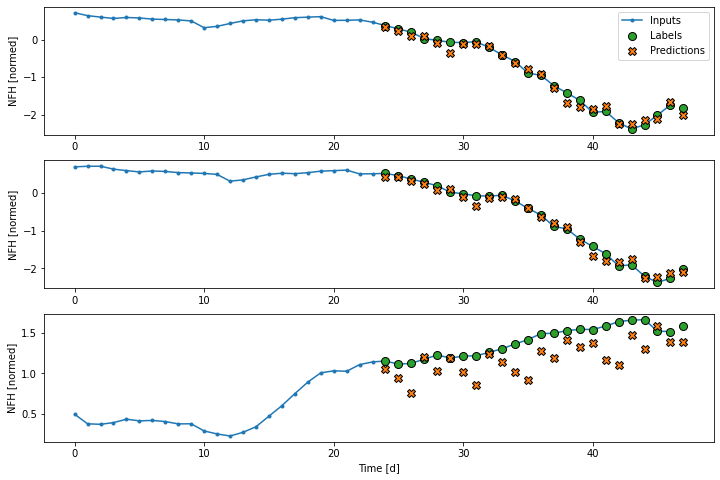

In [ ]:
wide_conv_window2.plot(conv_model,plot_col='NFH')

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

Predicions in 24 days time.

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window1.example[0].shape)
print('Output shape:', lstm_model(wide_window1.example[0]).shape)
print('Input shape:', wide_window2.example[0].shape)
print('Output shape:', lstm_model(wide_window2.example[0]).shape)

Input shape: (32, 24, 20)
Output shape: (32, 24, 1)
Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window1)

IPython.display.clear_output()
val_performance['LSTM1'] = lstm_model.evaluate(wide_window1.val)
performance['LSTM1'] = lstm_model.evaluate(wide_window1.test, verbose=0)

2/2 [==============================] - 0s 7ms/step - loss: 0.7130 - mean_absolute_error: 0.7555


In [ ]:
history = compile_and_fit(lstm_model, wide_window2)

IPython.display.clear_output()
val_performance['LSTM2'] = lstm_model.evaluate(wide_window2.val)
performance['LSTM2'] = lstm_model.evaluate(wide_window2.test, verbose=0)

2/2 [==============================] - 0s 8ms/step - loss: 0.1211 - mean_absolute_error: 0.2422


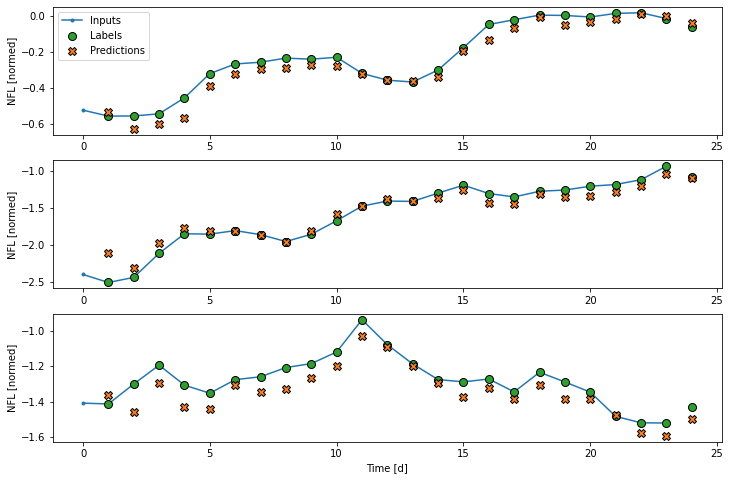

In [ ]:
wide_window1.plot(lstm_model,'NFL')

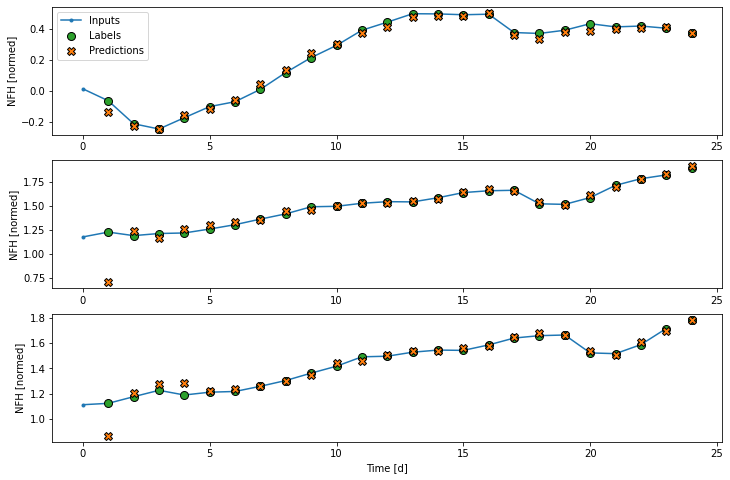

In [ ]:
wide_window2.plot(lstm_model,'NFH')

### Performance

With this dataset typically each of the models does slightly better than the one before it.

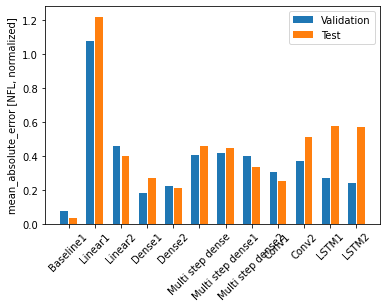

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [NFL, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Here, Model1 and Model2 each correspond to NFL and NFH.

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline1   : 0.0354
Linear1     : 1.2196
Linear2     : 0.3978
Dense1      : 0.2695
Dense2      : 0.2092
Multi step dense: 0.4578
Multi step dense1: 0.4469
Multi step dense2: 0.3337
Conv1       : 0.2530
Conv2       : 0.5096
LSTM1       : 0.5762
LSTM2       : 0.5689


### Multi-output models

The models so far all predicted a single output feature, `NFL`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 20)
Labels shape (batch, time, features): (32, 24, 20)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

2/2 [==============================] - 0s 7ms/step - loss: 1.4089 - mean_absolute_error: 0.6997


#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 5ms/step - loss: 0.8176 - mean_absolute_error: 0.6357


#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

2/2 [==============================] - 0s 8ms/step - loss: 1.0131 - mean_absolute_error: 0.7349

CPU times: user 5.25 s, sys: 390 ms, total: 5.64 s
Wall time: 5.07 s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

2/2 [==============================] - 0s 8ms/step - loss: 1.3077 - mean_absolute_error: 0.6786

CPU times: user 6.47 s, sys: 388 ms, total: 6.86 s
Wall time: 6.55 s


#### Performance

Here is the overall performance for these multi-output models.

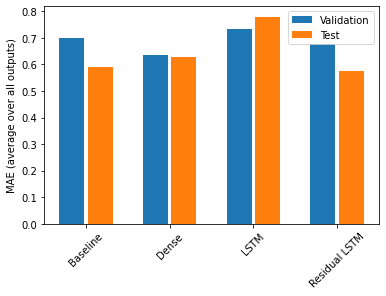

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.5920
Dense          : 0.6298
LSTM           : 0.7793
Residual LSTM  : 0.5748


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1d into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


Total window size: 20
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10 11 12 13 14 15 16 17 18 19]
Label column name(s): None

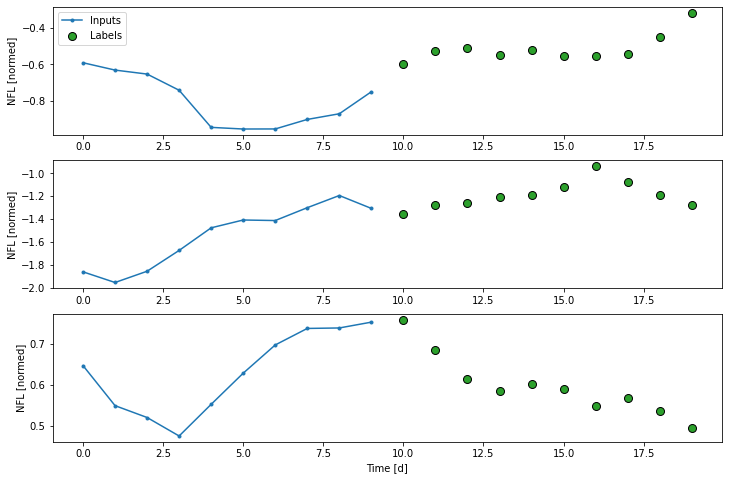

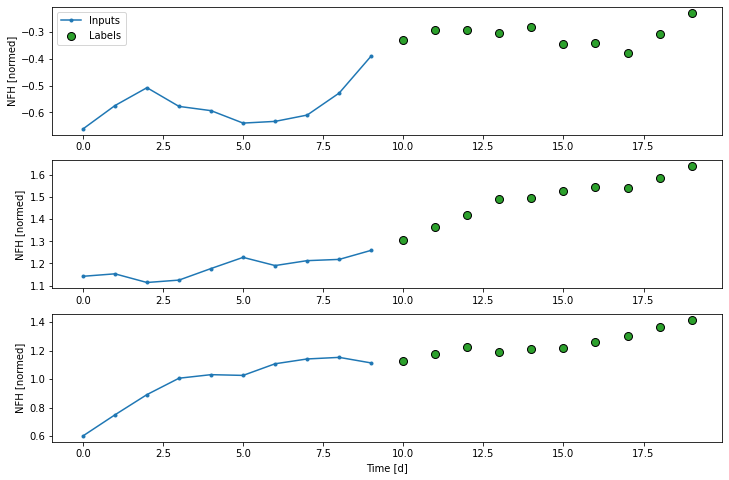

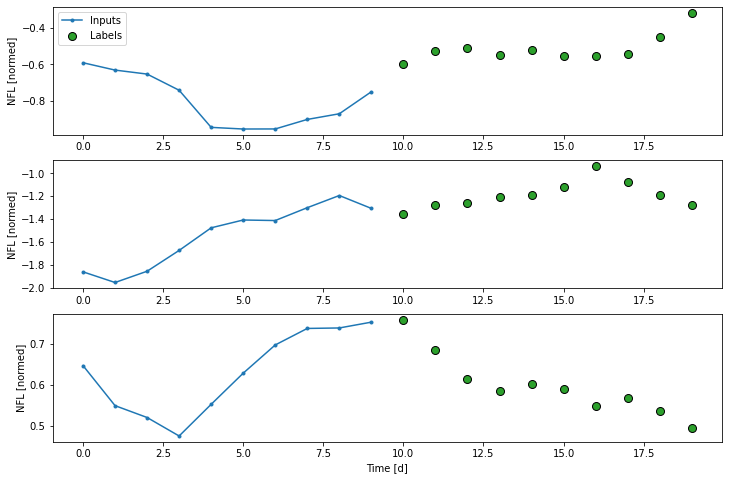

In [ ]:
OUT_STEPS = 10
multi_window1 = WindowGenerator(input_width=10,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window1.plot(plot_col='NFL')
multi_window2 = WindowGenerator(input_width=10,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window2.plot(plot_col='NFH')
multi_window1.plot(plot_col='NFL')
multi_window2

In [ ]:
multi_window1


Total window size: 20
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10 11 12 13 14 15 16 17 18 19]
Label column name(s): None

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

2/2 [==============================] - 0s 7ms/step - loss: 1.3692 - mean_absolute_error: 0.7364


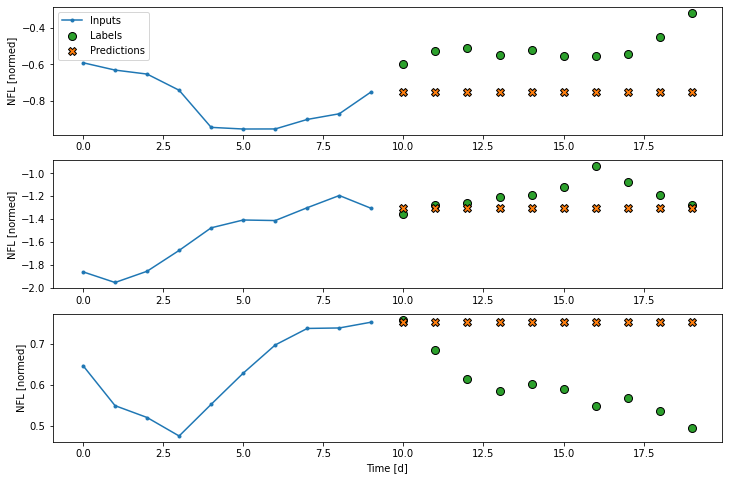

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last1'] = last_baseline.evaluate(multi_window1.val)
multi_performance['Last1'] = last_baseline.evaluate(multi_window1.test, verbose=0)
multi_window1.plot(last_baseline,'NFL')

2/2 [==============================] - 0s 7ms/step - loss: 1.3692 - mean_absolute_error: 0.7364


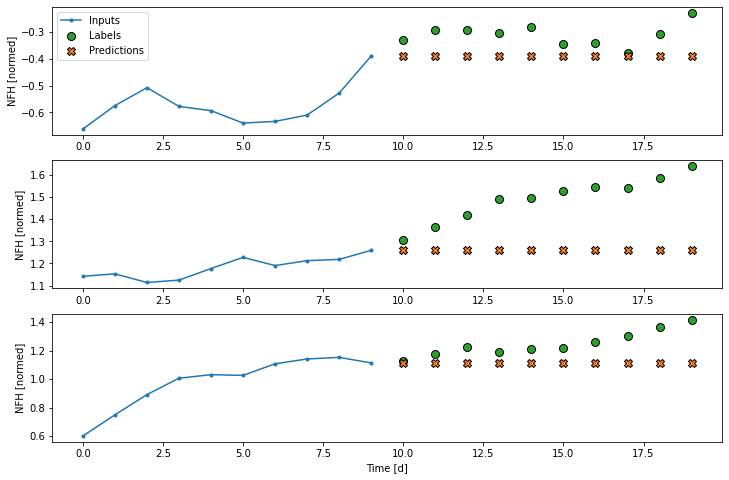

In [ ]:
multi_val_performance['Last2'] = last_baseline.evaluate(multi_window2.val)
multi_performance['Last2'] = last_baseline.evaluate(multi_window2.test, verbose=0)
multi_window2.plot(last_baseline,'NFH')

2/2 [==============================] - 0s 7ms/step - loss: 1.4517 - mean_absolute_error: 0.7855


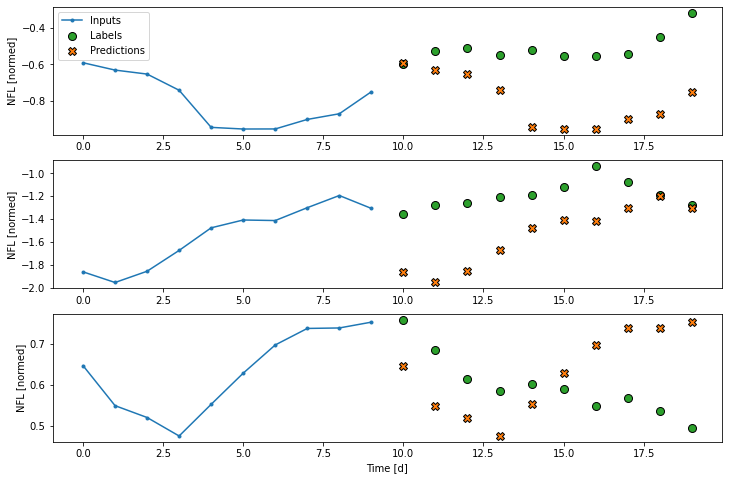

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat1'] = repeat_baseline.evaluate(multi_window1.val)
multi_performance['Repeat1'] = repeat_baseline.evaluate(multi_window1.test, verbose=0)
multi_window1.plot(repeat_baseline,'NFL')

2/2 [==============================] - 0s 7ms/step - loss: 1.4517 - mean_absolute_error: 0.7855


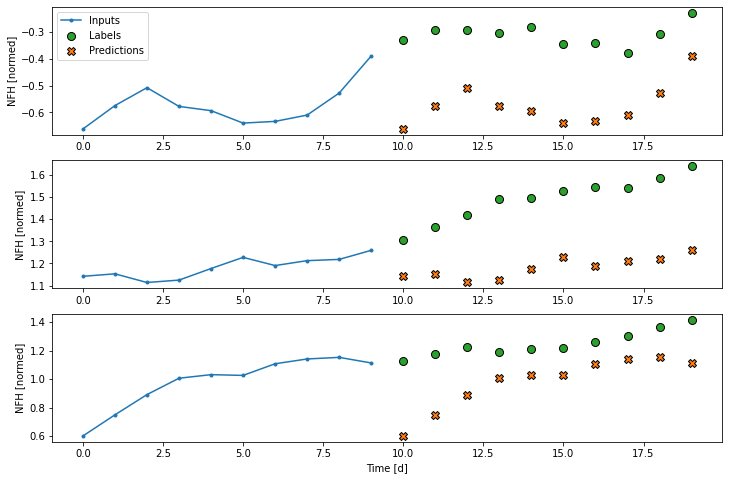

In [ ]:
multi_val_performance['Repeat2'] = repeat_baseline.evaluate(multi_window2.val)
multi_performance['Repeat2'] = repeat_baseline.evaluate(multi_window2.test, verbose=0)
multi_window2.plot(repeat_baseline,'NFH')

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

2/2 [==============================] - 0s 18ms/step - loss: 1.1040 - mean_absolute_error: 0.7949


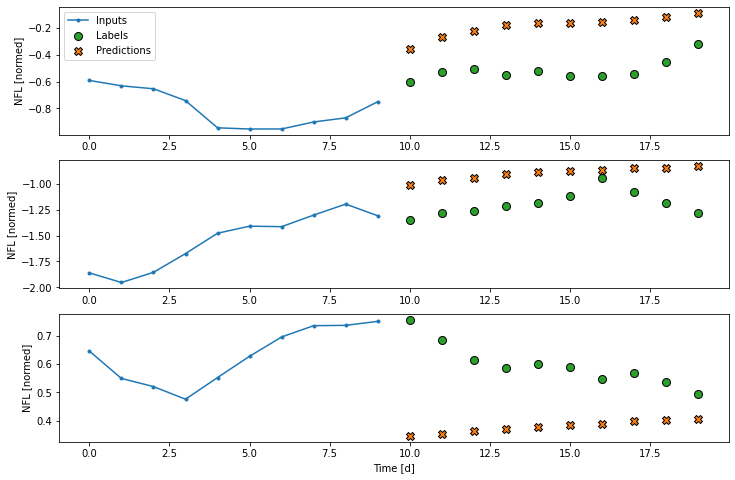

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window1)

IPython.display.clear_output()
multi_val_performance['Linear1'] = multi_linear_model.evaluate(multi_window1.val)
multi_performance['Linear1'] = multi_linear_model.evaluate(multi_window1.test, verbose=0)
multi_window1.plot(multi_linear_model,'NFL')

Epoch 1/20
8/8 [==============================] - 1s 44ms/step - loss: 0.7843 - mean_absolute_error: 0.5906 - val_loss: 1.0771 - val_mean_absolute_error: 0.7833
Epoch 2/20
8/8 [==============================] - 0s 20ms/step - loss: 0.7771 - mean_absolute_error: 0.5855 - val_loss: 1.0518 - val_mean_absolute_error: 0.7717
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 0.7728 - mean_absolute_error: 0.5821 - val_loss: 1.0283 - val_mean_absolute_error: 0.7601
Epoch 4/20
8/8 [==============================] - 0s 18ms/step - loss: 0.7692 - mean_absolute_error: 0.5793 - val_loss: 1.0076 - val_mean_absolute_error: 0.7495
Epoch 5/20
8/8 [==============================] - 0s 17ms/step - loss: 0.7664 - mean_absolute_error: 0.5770 - val_loss: 0.9883 - val_mean_absolute_error: 0.7389
Epoch 6/20
8/8 [==============================] - 0s 19ms/step - loss: 0.7635 - mean_absolute_error: 0.5747 - val_loss: 0.9725 - val_mean_absolute_error: 0.7296
Epoch 7/20
8/8 [==================

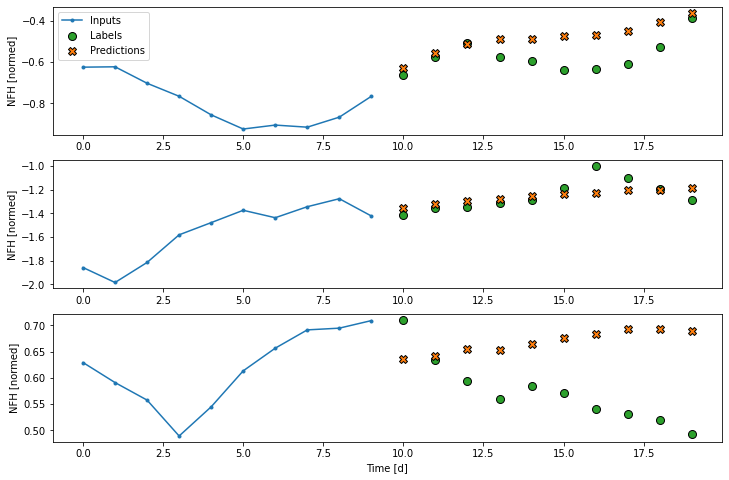

In [ ]:
history = compile_and_fit(multi_linear_model, multi_window2)
multi_val_performance['Linear2'] = multi_linear_model.evaluate(multi_window2.val)
multi_performance['Linear2'] = multi_linear_model.evaluate(multi_window2.test, verbose=0)
multi_window1.plot(multi_linear_model,'NFH')

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

2/2 [==============================] - 0s 9ms/step - loss: 0.8421 - mean_absolute_error: 0.6389


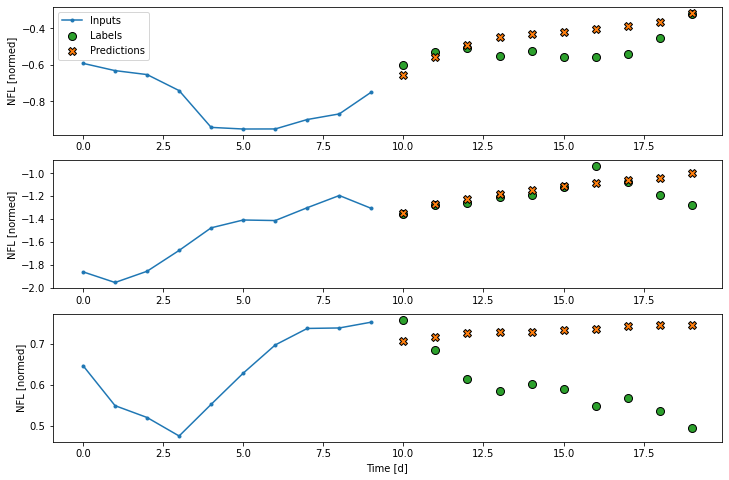

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window1)

IPython.display.clear_output()
multi_val_performance['Dense1'] = multi_dense_model.evaluate(multi_window1.val)
multi_performance['Dense1'] = multi_dense_model.evaluate(multi_window1.test, verbose=0)
multi_window1.plot(multi_dense_model,'NFL')

Epoch 1/20
8/8 [==============================] - 1s 50ms/step - loss: 0.6935 - mean_absolute_error: 0.5365 - val_loss: 0.8552 - val_mean_absolute_error: 0.6291
Epoch 2/20
8/8 [==============================] - 0s 15ms/step - loss: 0.6721 - mean_absolute_error: 0.5274 - val_loss: 0.8457 - val_mean_absolute_error: 0.6212
Epoch 3/20
8/8 [==============================] - 0s 19ms/step - loss: 0.6665 - mean_absolute_error: 0.5252 - val_loss: 0.8632 - val_mean_absolute_error: 0.6313
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.8830 - mean_absolute_error: 0.6405


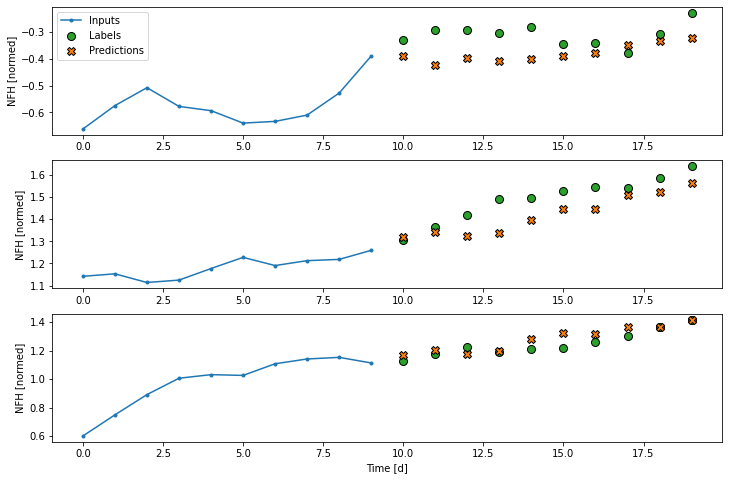

In [ ]:
history = compile_and_fit(multi_dense_model, multi_window2)
multi_val_performance['Dense2'] = multi_dense_model.evaluate(multi_window2.val)
multi_performance['Dense2'] = multi_dense_model.evaluate(multi_window2.test, verbose=0)
multi_window2.plot(multi_dense_model,'NFH')

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

2/2 [==============================] - 0s 9ms/step - loss: 0.8452 - mean_absolute_error: 0.6302


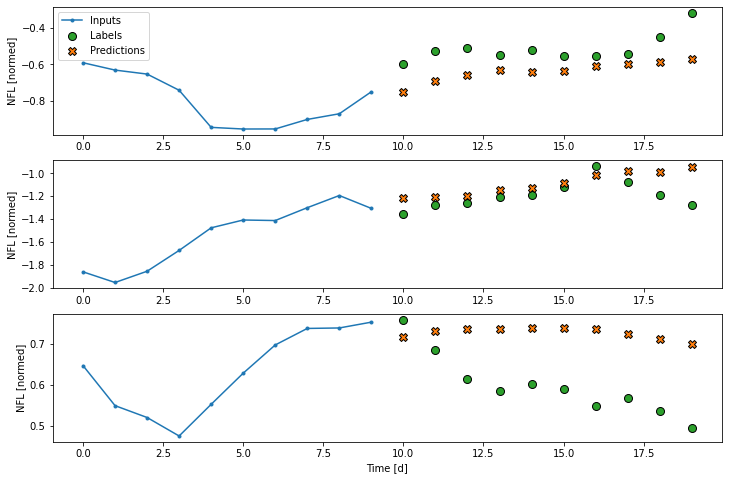

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window1)

IPython.display.clear_output()

multi_val_performance['Conv1'] = multi_conv_model.evaluate(multi_window1.val)
multi_performance['Conv1'] = multi_conv_model.evaluate(multi_window1.test, verbose=0)
multi_window1.plot(multi_conv_model,'NFL')

Epoch 1/20
8/8 [==============================] - 1s 43ms/step - loss: 0.6946 - mean_absolute_error: 0.5378 - val_loss: 0.8587 - val_mean_absolute_error: 0.6355
Epoch 2/20
8/8 [==============================] - 0s 22ms/step - loss: 0.6718 - mean_absolute_error: 0.5249 - val_loss: 0.8615 - val_mean_absolute_error: 0.6357
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 0.8658 - mean_absolute_error: 0.6377


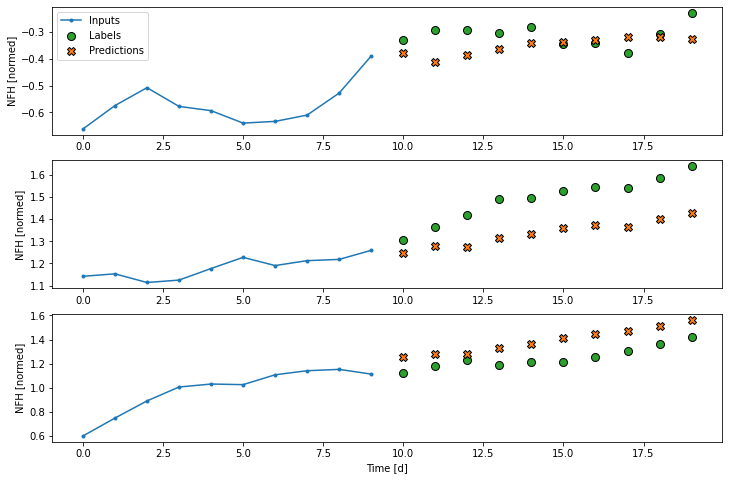

In [ ]:
history = compile_and_fit(multi_conv_model, multi_window2)

multi_val_performance['Conv2'] = multi_conv_model.evaluate(multi_window2.val)
multi_performance['Conv2'] = multi_conv_model.evaluate(multi_window2.test, verbose=0)
multi_window2.plot(multi_conv_model,'NFH')

#### RNN

2/2 [==============================] - 0s 6ms/step - loss: 1.0300 - mean_absolute_error: 0.7629


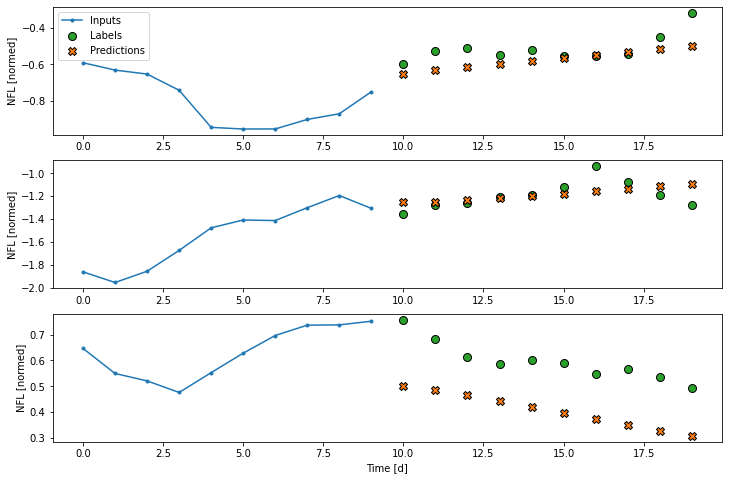

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window1)

IPython.display.clear_output()

multi_val_performance['LSTM1'] = multi_lstm_model.evaluate(multi_window1.val)
multi_performance['LSTM1'] = multi_lstm_model.evaluate(multi_window1.test, verbose=0)
multi_window1.plot(multi_lstm_model,'NFL')

2/2 [==============================] - 0s 11ms/step - loss: 0.9454 - mean_absolute_error: 0.7205


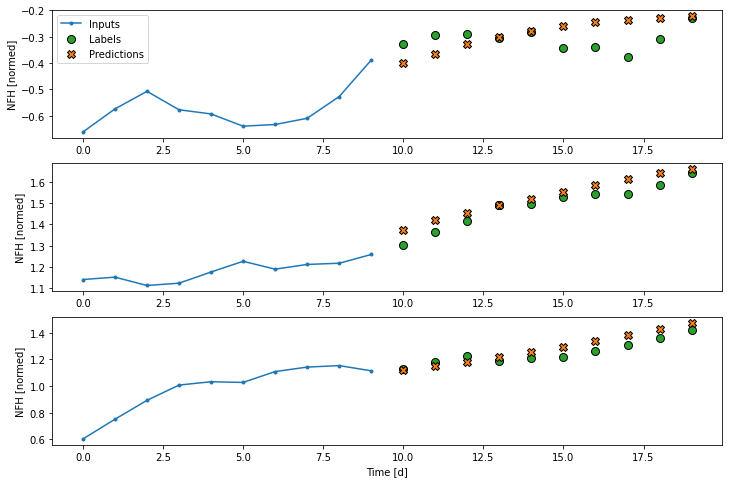

In [ ]:
history = compile_and_fit(multi_lstm_model, multi_window2)

IPython.display.clear_output()

multi_val_performance['LSTM2'] = multi_lstm_model.evaluate(multi_window2.val)
multi_performance['LSTM2'] = multi_lstm_model.evaluate(multi_window2.test, verbose=0)
multi_window2.plot(multi_lstm_model,'NFH')

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [ ]:
prediction1, state = feedback_model.warmup(multi_window1.example[0])
prediction1.shape

TensorShape([32, 20])

In [ ]:
prediction2, state = feedback_model.warmup(multi_window2.example[0])
prediction2.shape

TensorShape([32, 20])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window1.example[0]).shape)

Output shape (batch, time, features):  (32, 10, 20)


In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window2.example[0]).shape)

Output shape (batch, time, features):  (32, 10, 20)


Now train the model:

2/2 [==============================] - 0s 15ms/step - loss: 1.0475 - mean_absolute_error: 0.7666


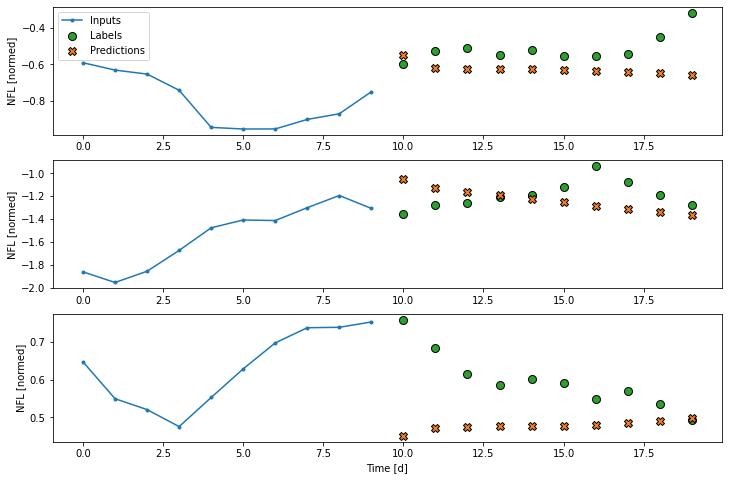

In [ ]:
history = compile_and_fit(feedback_model, multi_window1)

IPython.display.clear_output()

multi_val_performance['AR LSTM1'] = feedback_model.evaluate(multi_window1.val)
multi_performance['AR LSTM1'] = feedback_model.evaluate(multi_window1.test, verbose=0)
multi_window1.plot(feedback_model,'NFL')

2/2 [==============================] - 0s 15ms/step - loss: 1.0624 - mean_absolute_error: 0.7742


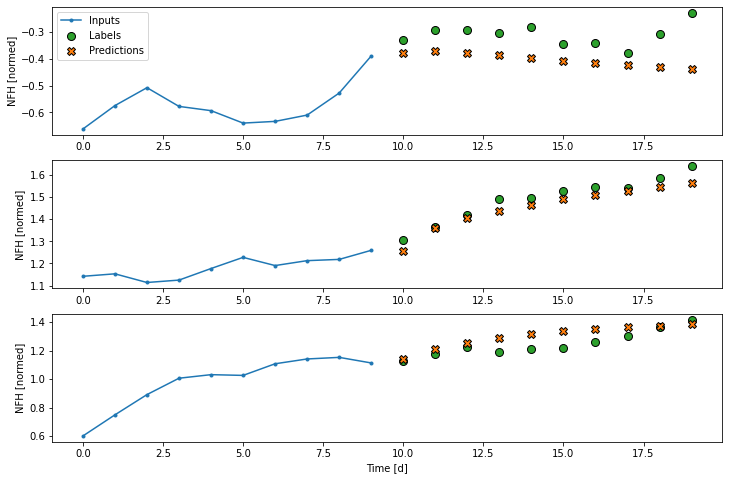

In [ ]:
history = compile_and_fit(feedback_model, multi_window2)

IPython.display.clear_output()

multi_val_performance['AR LSTM2'] = feedback_model.evaluate(multi_window2.val)
multi_performance['AR LSTM2'] = feedback_model.evaluate(multi_window2.test, verbose=0)
multi_window2.plot(feedback_model,'NFH')

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

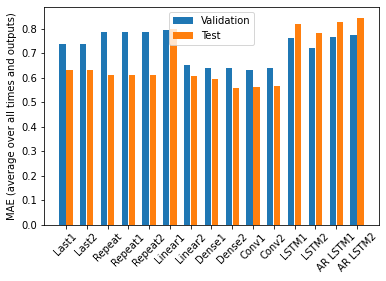

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

# Again, Model1 and Model2 are metrics corresponding to NFL and NFH

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last1   : 0.6321
Last2   : 0.6321
Repeat  : 0.6085
Repeat1 : 0.6085
Repeat2 : 0.6085
Linear1 : 0.7966
Linear2 : 0.6069
Dense1  : 0.5957
Dense2  : 0.5565
Conv1   : 0.5630
Conv2   : 0.5661
LSTM1   : 0.8166
LSTM2   : 0.7837
AR LSTM1: 0.8283
AR LSTM2: 0.8448


# Comparison:
Both tutorials were pretty similar except for the fact autogluon does all the data preprocessing and selection of models for you. Although the automated approach is pretty convenient , nift and scalable, it's still not as customizable as the keras/tensorflow tutorial where you can build the most diverse models possible and choose which structure the perceptrons interact with each other.